In [138]:
import os
import matplotlib.pyplot as plt
import numpy as np

csv_files = [f for f in os.listdir('..') if f.endswith('.csv')]

In [139]:
def plot_performance_4x1(dataframe):
    # Extract unique test names
    test_names = dataframe["Test Name"].unique()

    # Create the subplots
    fig, axs = plt.subplots(1, 4, figsize=(12, 5))  # 4 rows, 1 column

    # Loop through each test name and plot the performance
    for i, test_name in enumerate(test_names):
        # Filter data for the current test name
        test_data = dataframe[dataframe["Test Name"] == test_name]

        # Extract data for the current test name
        threads = test_data["Threads"]
        ora_ops_sec = test_data["ora_ops_sec"]
        pg_ops_sec = test_data["pg_ops_sec"]

        # Define x positions
        x = np.arange(len(threads))

        # Bar width
        width = 0.35

        # Plot on the respective subplot
        ax = axs[i]
        ax.bar(x - width/2, ora_ops_sec, width, label="Oracle", color="blue")
        ax.bar(x + width/2, pg_ops_sec, width, label="PostgreSQL", color="orange")

        # Add labels, title, and legend
        ax.set_title(f"{test_name}", fontsize=8)
        ax.set_xlabel('Threads', fontsize=12)
        ax.set_ylabel('Operations/sec', fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(threads)
        ax.legend()

    # Adjust spacing
    plt.tight_layout()
    plt.show()


def plot_performance(dataframe, title):


    # Extract data
    threads = dataframe["Threads"]
    ora_ops_sec = dataframe["ora_ops_sec"]
    pg_ops_sec = dataframe["pg_ops_sec"]

    # Define x positions
    x = np.arange(len(threads))

    # Bar width
    width = 0.35

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, ora_ops_sec, width, label="Oracle", color="blue")
    ax.bar(x + width/2, pg_ops_sec, width, label="PostgreSQL", color="orange")

    # Add labels, title, and legend
    ax.set_xlabel('Threads', fontsize=12)
    ax.set_ylabel('Operations/sec', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(threads)
    ax.legend()

    # Show the chart
    plt.tight_layout()
    plt.show()

In [148]:
import duckdb

# Connect to an in-memory DuckDB instance
con = duckdb.connect()

# Load CSV files into DuckDB
for csv_file in csv_files:
    table_name = csv_file.replace('.csv', '')
    con.execute(f"CREATE TABLE {table_name} AS SELECT * FROM read_csv_auto('../{csv_file}')")

# List tables to confirm
con.execute("SHOW TABLES").fetchall()

[('ORACLE_create_tables',),
 ('ORACLE_indexes',),
 ('ORACLE_ingest',),
 ('ORACLE_mixed',),
 ('ORACLE_selects',),
 ('ORACLE_updates',),
 ('POSTGRESQL_create_tables',),
 ('POSTGRESQL_indexes',),
 ('POSTGRESQL_ingest',),
 ('POSTGRESQL_mixed',),
 ('POSTGRESQL_selects',),
 ('POSTGRESQL_updates',)]

In [141]:
con.execute("SHOW TABLES").df()

,name
0,ORACLE_create_tables
1,ORACLE_indexes
2,ORACLE_ingest
3,ORACLE_mixed
4,ORACLE_selects
5,ORACLE_updates
6,POSTGRESQL_create_tables
7,POSTGRESQL_indexes
8,POSTGRESQL_ingest
9,POSTGRESQL_mixed


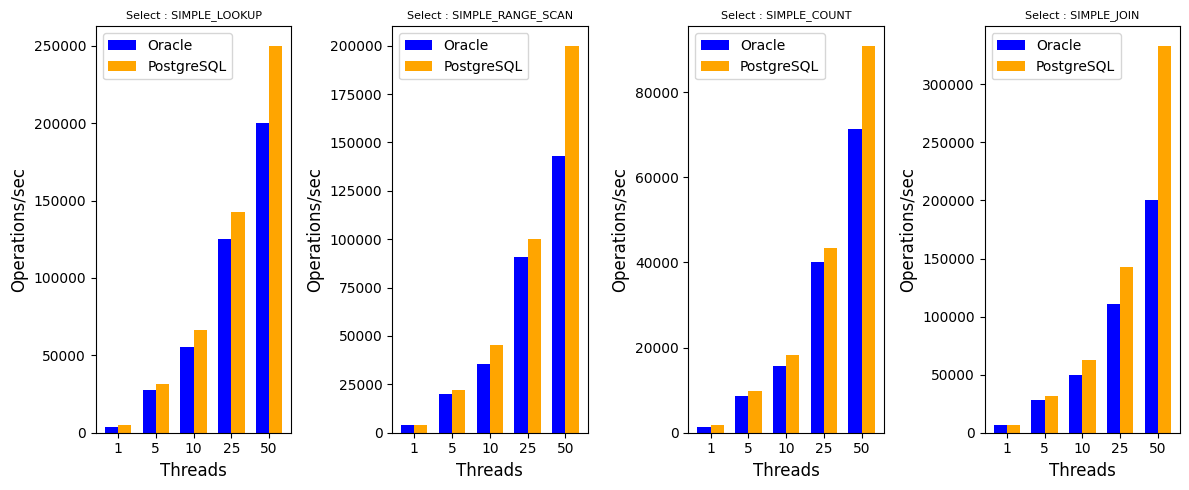

In [142]:
sdf = con.execute('''SELECT o."Test Name", o."Threads", o."Operations/sec" as ora_ops_sec, p."Operations/sec" as pg_ops_sec
                FROM ORACLE_selects o JOIN POSTGRESQL_selects p
                ON o."Test Name" = p."Test Name"
                and o."Operations" = p."Operations"
                and o."Threads" = p."Threads"
                and o."Batch" = p."Batch"
                and o."Async" = p."Async"
            ''').df()
plot_performance_4x1(sdf)

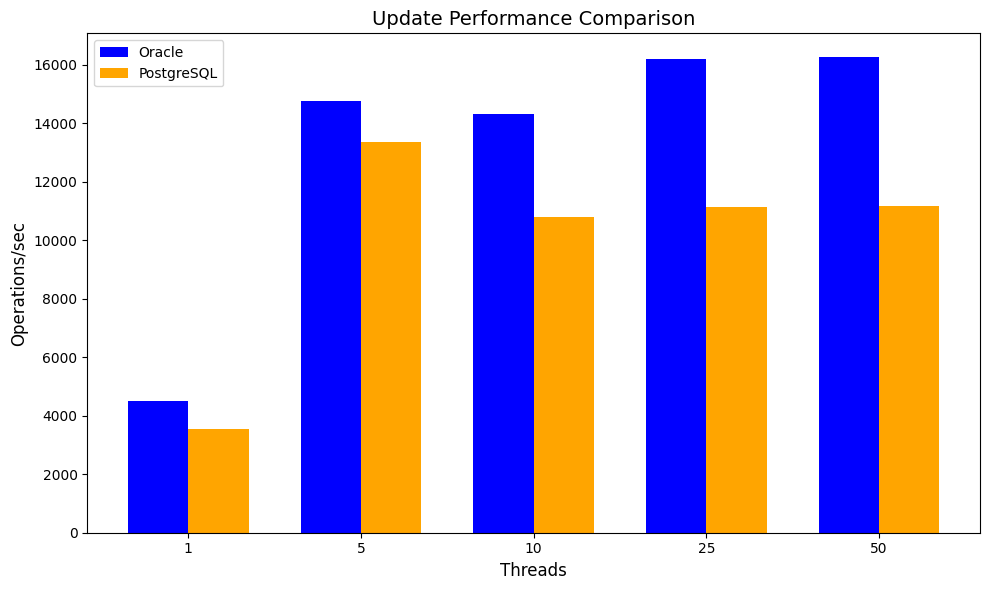

In [143]:
udf = con.execute('''SELECT o."Test Name", o."Threads", o."Operations/sec" as ora_ops_sec, p."Operations/sec" as pg_ops_sec
                FROM ORACLE_updates o JOIN POSTGRESQL_updates p
                ON o."Test Name" = p."Test Name"
                and o."Operations" = p."Operations"
                and o."Threads" = p."Threads"
                and o."Batch" = p."Batch"
                and o."Async" = p."Async"
            ''').df()
plot_performance(udf, "Update Performance Comparison")

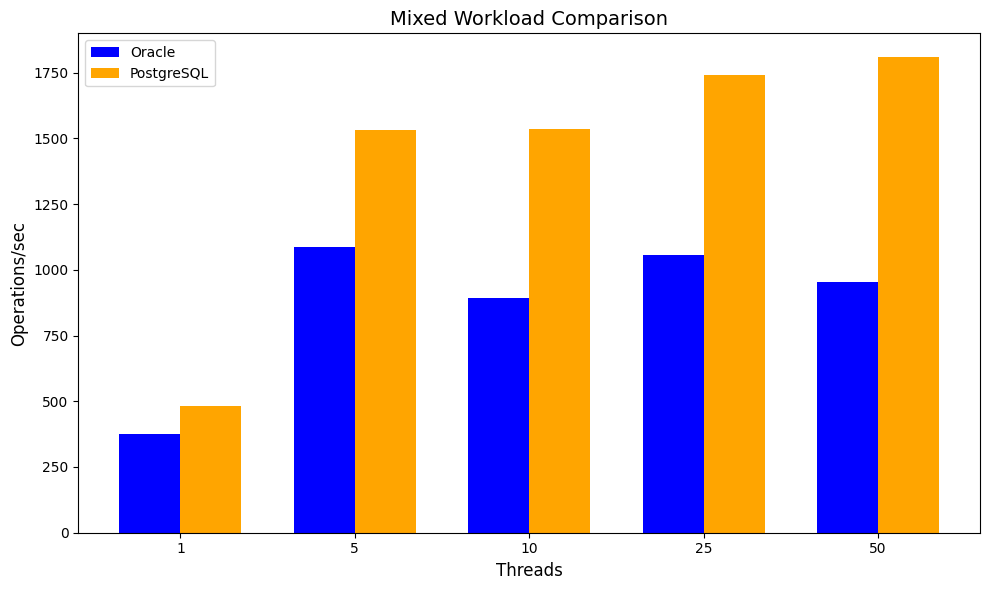

In [144]:
mdf = con.execute('''SELECT o."Test Name", o."Threads", o."Operations/sec" as ora_ops_sec, p."Operations/sec" as pg_ops_sec
                FROM ORACLE_mixed o JOIN POSTGRESQL_mixed p
                ON o."Test Name" = p."Test Name"
                and o."Operations" = p."Operations"
                and o."Threads" = p."Threads"
                and o."Batch" = p."Batch"
                and o."Async" = p."Async"
            ''').df()
plot_performance(mdf, "Mixed Workload Comparison")

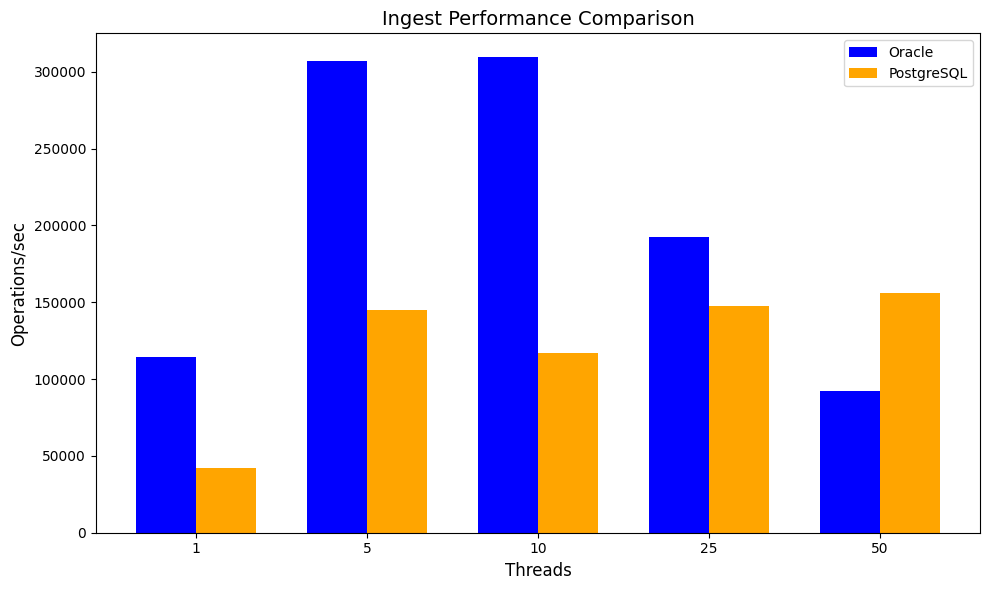

In [145]:
idf = con.execute('''SELECT o."Test Name", o."Threads", o."Operations/sec" as ora_ops_sec, p."Operations/sec" as pg_ops_sec
                FROM ORACLE_ingest o JOIN POSTGRESQL_ingest p
                ON o."Test Name" = p."Test Name"
                and o."Operations" = p."Operations"
                and o."Threads" = p."Threads"
                and o."Batch" = p."Batch"
                and o."Async" = p."Async"
            ''').df()

plot_performance(idf, "Ingest Performance Comparison")

In [152]:
con.execute('''select o."Test Name", o."Total Time" as ora_totaltime_ms, p."Total Time" as pg_totaltime_ms
               from ORACLE_create_tables o join POSTGRESQL_create_tables p on
               o."Test Name" = p."Test Name"''').df()

,Test Name,ora_totaltime_ms,pg_totaltime_ms
0,Create Tables,12012,1102


In [151]:
con.execute('''select o."Total Time" as ora_totaltime_ms, p."Total Time" as pg_totaltime_ms
               from ORACLE_indexes o join POSTGRESQL_indexes p on
               o."Test Name" = p."Test Name"''').df()

BinderException: Binder Error: Table "o" does not have a column named "Test Name"

Candidate bindings: : "column0"

LINE 3:                o."Test Name" = p."Test Name"
                       ^

In [101]:
con.execute('select * from postgresql_indexes').df()

,column0,column1,column2,column3
0,Create Indexes,12,001,POSTGRESQL
